In [78]:
from importlib import reload
import model_functions
reload(model_functions)
from model_functions import plot_ground_heigth, plot_alpha_scores, fit_model_with_files, load_and_prepare_data
import file_functions
reload(file_functions)
from file_functions import get_filepaths_in_folder_with_ending
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold

# 1. Visualize preprocessed flight data

In [49]:
data_dir = "train_data"
flight_id = '08412468-26ac-4777-9afb-4671f426277b'

parquet_path = os.path.join('..', 'data_process', data_dir, f"{flight_id}.parquet")

df = pd.read_parquet(parquet_path)

#df.info()
print(df.head())

                                                6417134  28827303  45268905  \
TimeStamp                        FrameCounter                                 
2024-02-14 06:46:58.397576+00:00 0             0.457152       0.0       0.0   
2024-02-14 06:46:58.416348+00:00 1             0.457152       0.0       0.0   
2024-02-14 06:47:00.886922+00:00 2             0.457152       0.0       0.0   
2024-02-14 06:47:00.894921+00:00 3             0.457152       0.0       0.0   
2024-02-14 06:47:00.926924+00:00 4             0.457152       0.0       0.0   

                                               108790465  117182271  \
TimeStamp                        FrameCounter                         
2024-02-14 06:46:58.397576+00:00 0                  75.0   2.312171   
2024-02-14 06:46:58.416348+00:00 1                  75.0   2.312171   
2024-02-14 06:47:00.886922+00:00 2                  75.0   2.309550   
2024-02-14 06:47:00.894921+00:00 3                  75.0   2.309550   
2024-02-14 06:47:00.

In [50]:
print(df.columns)
print(df.index)

Index(['6417134', '28827303', '45268905', '108790465', '117182271',
       '156751662', '156875280', '192589766', '203733126', '301190512',
       ...
       '4054750327', '4056189073', '4058842283', '4065458540', '4066202059',
       '4174711423', '4247030081', '4264003232', '4294814812', 'Label'],
      dtype='object', length=141)
MultiIndex([('2024-02-14 06:46:58.397576+00:00',      0),
            ('2024-02-14 06:46:58.416348+00:00',      1),
            ('2024-02-14 06:47:00.886922+00:00',      2),
            ('2024-02-14 06:47:00.894921+00:00',      3),
            ('2024-02-14 06:47:00.926924+00:00',      4),
            ('2024-02-14 06:47:00.946964+00:00',      5),
            ('2024-02-14 06:47:00.950532+00:00',      6),
            ('2024-02-14 06:47:00.961775+00:00',      7),
            ('2024-02-14 06:47:00.978790+00:00',      8),
            ('2024-02-14 06:47:00.984390+00:00',      9),
            ...
            ('2024-02-14 07:03:21.102460+00:00', 253960),
           

<Axes: >

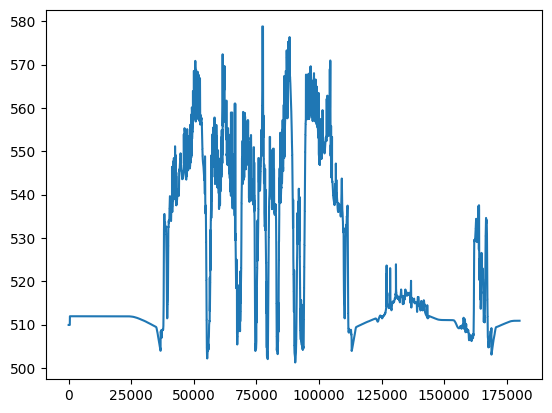

In [ ]:
plot_ground_heigth(df)

# 2. Read Label from preprocessed data

In [53]:
data_dir = "train_data"
flight_id = '08412468-26ac-4777-9afb-4671f426277b'
data_dir_path = os.path.join('..', 'data_process', data_dir)
parquet_path = os.path.join(data_dir_path, f"{flight_id}.parquet")
df = pd.read_parquet(parquet_path)

label_path = os.path.join(data_dir_path, f"{flight_id}.csv")
labels = pd.read_csv(label_path)
maneuvers = np.unique(labels["maneuver"])

print(maneuvers)
print(df['Label'])


['Autorotation' 'Climb' 'Descent' 'Hover' 'Left Turn' 'No Maneuver'
 'Right Turn' 'Straight and Level']
TimeStamp                         FrameCounter
2024-02-14 06:46:58.397576+00:00  0               No Maneuver
2024-02-14 06:46:58.416348+00:00  1               No Maneuver
2024-02-14 06:47:00.886922+00:00  2               No Maneuver
2024-02-14 06:47:00.894921+00:00  3               No Maneuver
2024-02-14 06:47:00.926924+00:00  4               No Maneuver
                                                     ...     
2024-02-14 07:03:21.182601+00:00  253965          No Maneuver
2024-02-14 07:03:21.202792+00:00  253966          No Maneuver
2024-02-14 07:03:21.215947+00:00  253967          No Maneuver
2024-02-14 07:03:21.235502+00:00  253968          No Maneuver
2024-02-14 07:03:21.249083+00:00  253969          No Maneuver
Name: Label, Length: 180148, dtype: object


# 3. Time-Series modifications

In [39]:
#TODO Time-Series specific data manipulation required ?

# 4. Lasso model and k-fold cross validation

Fit a linear regression classification lasso model and find the best alpha-parameter with the k-fold cross validation.
The goal of that is to get only the few most significant features, so that we can limit our preprocessing and future models to those columns.

In [ ]:
target_file_ending = '.parquet'

model = SGDClassifier(loss='log_loss', penalty='l1', alpha=0.01) # penalty 'L1' -> Lasso

train_file_paths = get_filepaths_in_folder_with_ending('train_data', target_file_ending)
validate_file_paths = get_filepaths_in_folder_with_ending('validate_data', target_file_ending)
model_train_file_paths = np.concatenate((train_file_paths, validate_file_paths))

columns = fit_model_with_files(model, model_train_file_paths, maneuvers)

' for i, file in enumerate(model_train_file_paths):\n    X, y = load_and_prepare_data(file)\n\n    # partial fit on each file\n    if i == 0:\n        model.partial_fit(X, y, classes=maneuvers)\n        #first_file = False\n    else:\n        model.partial_fit(X, y) '

In [77]:
coefficients = pd.DataFrame(model.coef_, columns=columns)

# identify unnecessary features (zero coefficients across all classes)
unnecessary_features = coefficients.columns[(coefficients == 0).all()].tolist()
print(len(unnecessary_features))

necessary_features = coefficients.columns[(coefficients != 0).any()].tolist()
print(len(necessary_features))
print(necessary_features)

77
63
['108790465', '117182271', '156875280', '301190512', '353872548', '513685691', '614270119', '637219977', '683661709', '731865654', '760531114', '855504072', '943710121', '1049691088', '1089322549', '1105598667', '1112206407', '1308053202', '1450782446', '1464341275', '1501357761', '1515452476', '1553784294', '1637431807', '1796138214', '1847367549', '1909389254', '1984892607', '2142867155', '2275361864', '2298125514', '2338387453', '2400822283', '2545498036', '2546226082', '2705846059', '2716830861', '2769157819', '2876656444', '2979223644', '3063191758', '3207956524', '3327788219', '3358452658', '3495907791', '3590140009', '3599019297', '3687766012', '3742756340', '3771464240', '3871827618', '3881043328', '3928845979', '3933014103', '3966668421', '3981973171', '4021288050', '4054750327', '4056189073', '4066202059', '4174711423', '4247030081', '4294814812']


Alpha: 0.005, Score: 0.039230196279003544
Alpha: 0.05, Score: 0.3592327956166406
Alpha: 0.1, Score: 0.2196944109201052
Alpha: 1, Score: 0.22984490619145415
Alpha: 5, Score: 0.06469673066372718
Alpha: 10, Score: 0.6460595580077603
Alpha: 50, Score: 0.6460595580077603
Alpha: 100, Score: 0.6460595580077603
Alpha: 200, Score: 0.6460595580077603
Alpha: 500, Score: 0.6460595580077603
Alpha: 1000, Score: 0.6460595580077603
Best Alpha: 10, Best CV Score: 0.6460595580077603


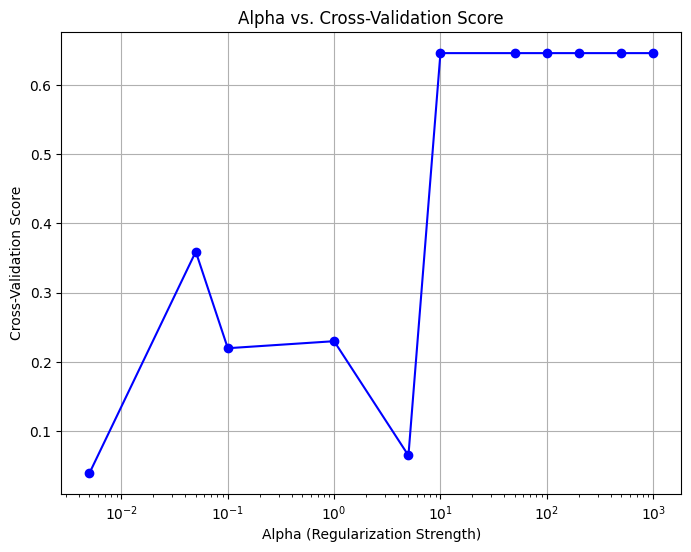

In [ ]:
alphas = [0.005, 0.05, 0.1, 1, 3, 5, 7, 10, 20, 50, 100, 200, 500, 1000]
kf = KFold(n_splits=4, shuffle=True)

best_alpha = None
best_score = -np.inf

alpha_scores = []
for alpha in alphas:
    scores = []

    for train_idx, val_idx in kf.split(model_train_file_paths):
        model = SGDClassifier(loss='log_loss', penalty='l1', alpha=alpha) # penalty 'L1' -> Lasso

        first_file = True
        # Train Split
        columns = fit_model_with_files(model, model_train_file_paths[[idx]], maneuvers)
    
        # Validation Split
        val_scores = []
        for idx in val_idx:
            X, y = load_and_prepare_data(model_train_file_paths[idx])   
            val_scores.append(model.score(X, y))

        scores.append(np.mean(val_scores))
    
    mean_score = np.mean(scores)
    alpha_scores.append((alpha, mean_score))
    print(f"Alpha: {alpha}, Score: {mean_score}")
    
    # Update the best alpha if needed
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}, Best CV Score: {best_score}")
plot_alpha_scores(alpha_scores) # adjust alphas according to plot

In [ ]:
final_model = SGDClassifier(loss='log_loss', penalty='l1', alpha=best_alpha)

columns = fit_model_with_files(final_model, model_train_file_paths, maneuvers)

In [81]:
coefficients = pd.DataFrame(final_model.coef_, columns=columns)

# identify unnecessary features (zero coefficients across all classes)
unnecessary_features = coefficients.columns[(coefficients == 0).all()].tolist()
print(f"Unnecessary: {len(unnecessary_features)}")

necessary_features = coefficients.columns[(coefficients != 0).any()].tolist()
print(f"Necessary: {len(necessary_features)}")
print(necessary_features)

Unnecessary: 113
Necessary: 27
['203733126', '353872548', '513685691', '610037603', '637219977', '760531114', '1105598667', '1112206407', '1464341275', '1515452476', '1847367549', '1909389254', '2142867155', '2400822283', '2546226082', '2716830861', '2979223644', '3063191758', '3590140009', '3742756340', '3771464240', '3871827618', '3981973171', '4021288050', '4054750327', '4056189073', '4174711423']


In [ ]:
# after running the lasso model, only following columns are relevant:
#